## Compare dataset filtering methods

Instead of applying our mutation count/percentage filters to samples from each cancer type independently, we could just look at the whole dataset - or in other words, we could choose genes to train classifiers for based on their overall percent/count of mutated samples.

This script compares the per-cancer type filtering method (or the "cancer_type" method) to the per-gene, across cancer types filtering method (or the "gene" method).

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
cancer_type_results_dir = Path(cfg.results_dirs['mutation'],
                               'merged_all',
                               'gene').resolve()

gene_results_dir = Path(cfg.results_dirs['mutation'],
                        'merged_filter_all',
                        'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

### Plot results with new filtering scheme

In [3]:
# load raw data
gene_results_df = au.load_stratified_prediction_results(gene_results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
gene_results_df = gene_results_df[gene_results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(gene_results_df.shape)
print(gene_results_df.seed.unique())
print(gene_results_df.training_data.unique())
gene_results_df.head()

(34944, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89034,0.251860,MAP3K1,expression,signal,42,train,0,gene
1,0.73233,0.114940,MAP3K1,expression,signal,42,test,0,gene
2,0.72119,0.086784,MAP3K1,expression,signal,42,cv,0,gene
3,0.82454,0.199700,MAP3K1,expression,signal,42,train,1,gene
4,0.71653,0.068720,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
gene_compressed_results_df = au.load_compressed_prediction_results(
    gene_results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(gene_compressed_results_df.shape)
print(gene_compressed_results_df.seed.unique())
print(gene_compressed_results_df.training_data.unique())
print(gene_compressed_results_df.n_dims.unique())
gene_compressed_results_df.head()

(17472, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.93132,0.313250,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.70463,0.055784,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.59976,0.034645,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,0.73641,0.076655,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.63619,0.045668,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
gene_results_df['n_dims'] = 'raw'
gene_results_df = pd.concat((gene_results_df, gene_compressed_results_df))
print(gene_results_df.seed.unique())
print(gene_results_df.training_data.unique())
print(gene_results_df.n_dims.unique())
print(gene_results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
gene_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
gene_results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(52416, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89034,0.251860,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.73233,0.114940,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.72119,0.086784,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.82454,0.199700,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.71653,0.068720,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
gene_all_results_df = au.compare_all_data_types(gene_results_df,
                                               SIG_ALPHA,
                                               metric='aupr')

gene_all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
145,PTEN,0.341941,4.116619e-10,7.492247e-08,True,gene expression,7.125388
31,CCND1,0.570285,9.424262e-10,8.576078e-08,True,gene expression,7.066711
99,LRP1B,0.130724,4.477528e-09,8.149102e-07,True,mutational signatures,6.088890
104,MDM2,0.505971,5.782611e-09,3.339322e-07,True,gene expression,6.476342
52,EGFR,0.409517,7.385793e-09,3.339322e-07,True,gene expression,6.476342
145,PTEN,0.314720,8.297077e-09,1.510068e-06,True,RPPA,5.821003
15,ATRX,0.254146,9.173961e-09,3.339322e-07,True,gene expression,6.476342
173,TP53,0.221191,1.539245e-08,4.669045e-07,True,gene expression,6.330772
59,ETV5,0.276989,2.902364e-08,6.543920e-07,True,gene expression,6.184162
55,ERBB2,0.330228,3.052583e-08,2.777850e-06,True,RPPA,5.556291


gene expression: 81/182
27k methylation: 16/182
450k methylation: 1/182


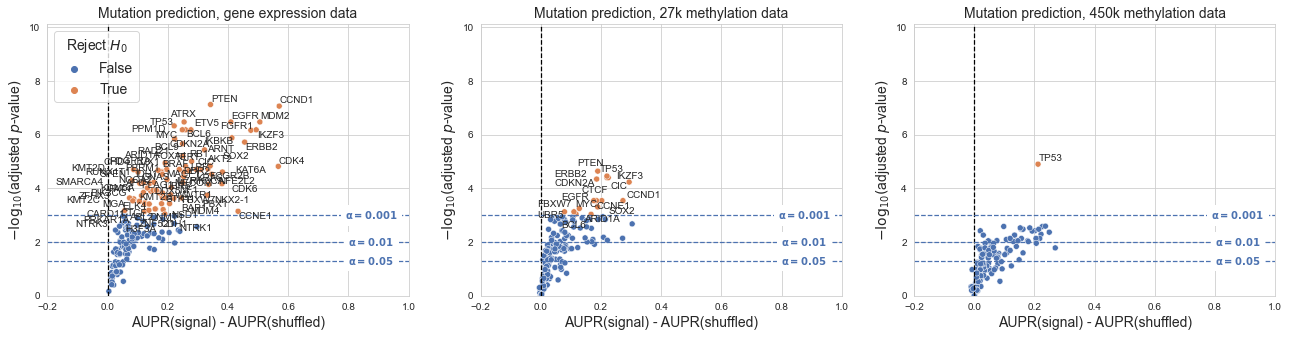

In [7]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(gene_all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

RPPA: 41/182
microRNA: 25/182
mutational signatures: 7/182


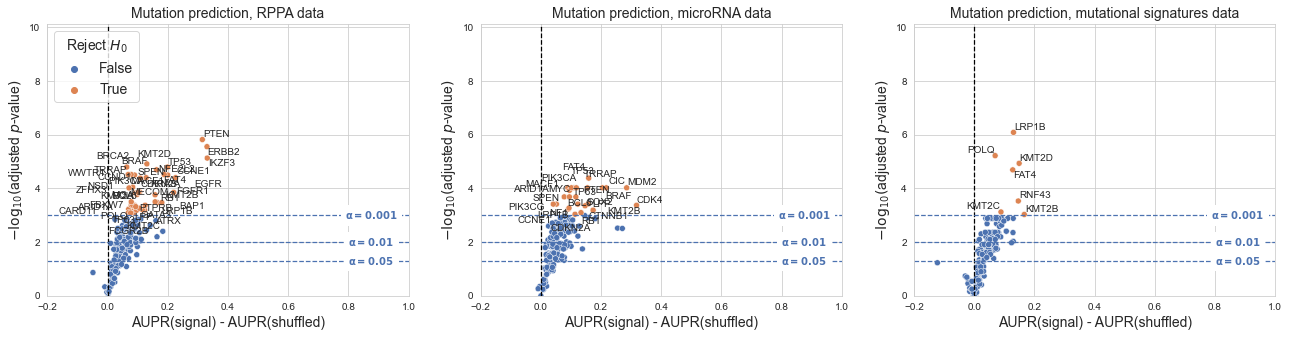

In [8]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(gene_all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

### Compare against results with old filtering scheme

In [9]:
# load raw data
cancer_type_results_df = au.load_stratified_prediction_results(cancer_type_results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
cancer_type_results_df = cancer_type_results_df[cancer_type_results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(cancer_type_results_df.shape)
print(cancer_type_results_df.seed.unique())
print(cancer_type_results_df.training_data.unique())
cancer_type_results_df.head()

(41376, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89764,0.716580,MAP3K1,expression,signal,42,train,0,gene
1,0.44982,0.075833,MAP3K1,expression,signal,42,test,0,gene
2,0.66546,0.300290,MAP3K1,expression,signal,42,cv,0,gene
3,0.98281,0.909130,MAP3K1,expression,signal,42,train,1,gene
4,0.85560,0.564490,MAP3K1,expression,signal,42,test,1,gene


In [10]:
# load compressed data for me_27k and me_450k
cancer_type_compressed_results_df = au.load_compressed_prediction_results(
    cancer_type_results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(cancer_type_compressed_results_df.shape)
print(cancer_type_compressed_results_df.seed.unique())
print(cancer_type_compressed_results_df.training_data.unique())
print(cancer_type_compressed_results_df.n_dims.unique())
cancer_type_compressed_results_df.head()

(20688, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.81326,0.45134,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.65695,0.28388,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.73856,0.45058,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [11]:
cancer_type_results_df['n_dims'] = 'raw'
cancer_type_results_df = pd.concat((cancer_type_results_df, cancer_type_compressed_results_df))
print(cancer_type_results_df.seed.unique())
print(cancer_type_results_df.training_data.unique())
print(cancer_type_results_df.n_dims.unique())
print(cancer_type_results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
cancer_type_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
cancer_type_results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(62064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89764,0.716580,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.44982,0.075833,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66546,0.300290,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98281,0.909130,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.85560,0.564490,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [12]:
cancer_type_all_results_df = au.compare_all_data_types(cancer_type_results_df,
                                               SIG_ALPHA,
                                               metric='aupr')

cancer_type_all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
23,BRAF,0.308046,6.123121e-10,1.328717e-07,True,27k methylation,6.876567
45,CIC,0.647034,1.880651e-09,4.081014e-07,True,450k methylation,6.389232
60,ERBB2,0.312735,2.905854e-09,3.152852e-07,True,27k methylation,6.501296
45,CIC,0.645135,3.558277e-09,7.721461e-07,True,gene expression,6.112301
56,EGFR,0.531508,9.779722e-09,8.999793e-07,True,gene expression,6.045767
60,ERBB2,0.537138,1.339592e-08,8.999793e-07,True,gene expression,6.045767
168,PTEN,0.229569,1.460109e-08,1.056146e-06,True,27k methylation,5.976276
207,TSC1,0.616890,1.745741e-08,8.999793e-07,True,gene expression,6.045767
30,CCND1,0.603684,2.073685e-08,8.999793e-07,True,gene expression,6.045767
204,TP53,0.202256,3.084420e-08,6.693192e-06,True,RPPA,5.174367


In [13]:
overlap_genes = (
    set(gene_all_results_df.gene.unique())
      .intersection(set(cancer_type_all_results_df.gene.unique()))
)

gene_all_results_df = gene_all_results_df[gene_all_results_df.gene.isin(overlap_genes)]
cancer_type_all_results_df = cancer_type_all_results_df[cancer_type_all_results_df.gene.isin(overlap_genes)]

cols = ['gene', 'training_data', 'delta_mean']
diff_df = (cancer_type_all_results_df
  .loc[:, cols]
  .merge(gene_all_results_df.loc[:, cols],
         left_on=['gene', 'training_data'],
         right_on=['gene', 'training_data'])
)

diff_df.rename(
    columns={'delta_mean_x': 'delta_mean_cancer_type',
             'delta_mean_y': 'delta_mean_gene'},
    inplace=True
)
diff_df['cancer_type_vs_gene'] = diff_df.delta_mean_cancer_type - diff_df.delta_mean_gene
diff_df.head()

,gene,training_data,delta_mean_cancer_type,delta_mean_gene,cancer_type_vs_gene
0,ABL2,gene expression,0.157714,0.123981,0.033733
1,ACVR2A,gene expression,0.221802,0.070957,0.150845
2,AFF3,gene expression,0.099245,0.041126,0.058119
3,ALK,gene expression,0.016024,0.024287,-0.008263
4,AMER1,gene expression,-0.015359,0.015703,-0.031062


Text(0, 0.5, '(Cancer type - gene) filtering scheme')

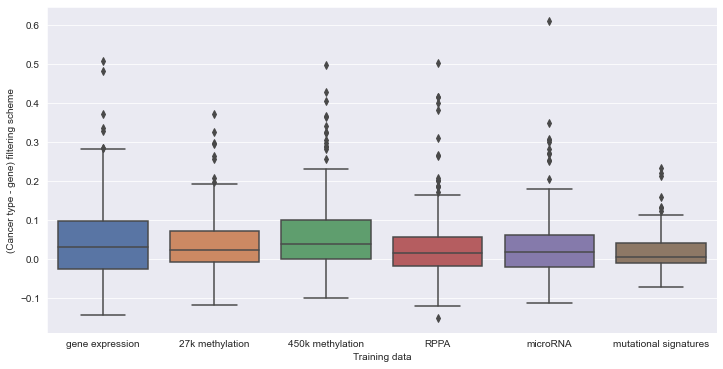

In [14]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=diff_df, x='training_data', y='cancer_type_vs_gene',
            order=training_data_map.values())
plt.xlabel('Training data')
plt.ylabel('(Cancer type - gene) filtering scheme')

Text(0.5, 1.0, 'Performance difference between cancer type and gene filtering scheme')

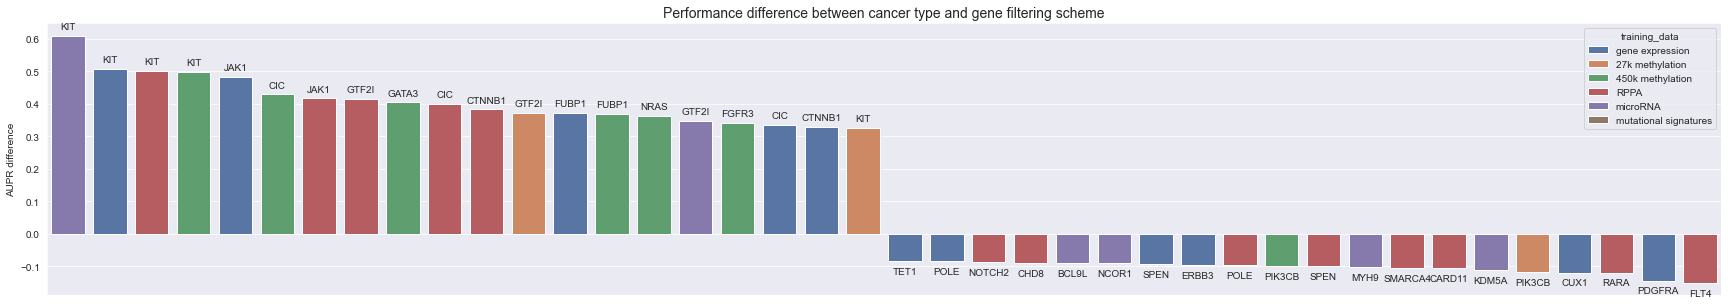

In [15]:
metric = 'aupr'
num_examples = 20

top_df = (diff_df
    .sort_values(by='cancer_type_vs_gene', ascending=False)
    .head(num_examples)
)
bottom_df = (diff_df
    .sort_values(by='cancer_type_vs_gene', ascending=False)
    .tail(num_examples)
)

plot_df = pd.concat((top_df, bottom_df)).reset_index()

sns.set({'figure.figsize': (30, 5)})
sns.barplot(data=plot_df, x=plot_df.index, y='cancer_type_vs_gene',
            hue='training_data', dodge=False,
            hue_order=training_data_map.values())

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, 'cancer_type_vs_gene']
        val = plot_df.loc[i, 'gene']
        if _y > 0:
            ax.text(_x, _y + 0.02, val, ha="center") 
        else:
            ax.text(_x, _y - 0.04, val, ha="center") 
        
show_values_on_bars(plt.gca())
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('AUPR difference')
plt.title('Performance difference between cancer type and gene filtering scheme', size=14)

The plots above show the difference for each gene between the "old" filtering scheme (per-cancer type) and the "new" filtering scheme (gene-level across all cancer types). A positive value for a gene means that gene's classifier performed better for the "old" filtering scheme and vice-versa for the "new" filtering scheme.

In the box plot, we can see that most genes have a positive old vs. new difference (means > 0 and small negative tails), indicating that filtering for each cancer type independently (the "old" approach) tends to lead to better classifier performance for most genes. This seems to hold across all the data types we looked at.

The bar plot shows the extremes on each end (i.e. genes with the largest negative or positive difference). The positive tails tend to be larger than the negative tails, supporting our observations from the box plot.